In [260]:
import imgaug.augmenters as iaa
import mlflow.pytorch
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm

import sys
sys.path.append('../../')

from src import MODELS_DIR, MLFLOW_TRACKING_URI, DATA_PATH
from src.data import TrainValTestSplitter, MURASubset
from src.data.transforms import GrayScale, Resize, HistEqualisation, MinMaxNormalization, ToTensor
from src.features.augmentation import Augmentation
from src.models.alphagan import AlphaGan
from src.models.sagan import SAGAN
from src.models.autoencoders import BottleneckAutoencoder, BaselineAutoencoder, SkipConnection
from src.models.gans import DCGAN
from src.models.vaetorch import VAE

from sklearn.metrics import roc_auc_score, average_precision_score


import matplotlib.pyplot as plt
%matplotlib inline

## Load sample image

In [2]:
run_params = {
    'image_resolution': (512, 512),
    'pipeline': {
        'hist_equalisation': False,
        'data_source': 'XR_HAND_PHOTOSHOP',
    }
}

augmentation_seq = iaa.Sequential([iaa.Affine(fit_output=False, rotate=(20), order=[0, 1]),  
                                   iaa.PadToFixedSize(*run_params['image_resolution'], position='center')])

composed_transforms = Compose([GrayScale(),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               Resize(run_params['image_resolution'], keep_aspect_ratio=True),
                               Augmentation(augmentation_seq),
                               MinMaxNormalization(),
                               ToTensor()])

In [3]:
# Loading image
image_path = f'{DATA_PATH}/{run_params["pipeline"]["data_source"]}/patient11178/study1_negative/image3_cropped_1.png'
image_path

'/home/ubuntu/xray/data/train/XR_HAND_PHOTOSHOP/patient11178/study1_negative/image3_cropped_1.png'

In [4]:
validation = MURASubset(filenames=[image_path], true_labels=[0],
                        patients=[11178], transform=composed_transforms)

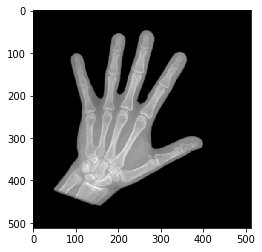

In [48]:
for batch in validation:
    inp_image = batch['image'].to('cpu')
inp_image_np = inp_image.numpy()
plt.imshow(inp_image_np[0,:,:], cmap='gray', vmin=0, vmax=1)
plt.savefig('inp_image.png', dpi=300)

## Baseline autoencoder

In [49]:
path_to_model = '/home/ubuntu/mlruns/1/5ca7f67c33674926a00590752c877fe5/artifacts/BaselineAutoencoder.pth'

In [50]:
model = torch.load(path_to_model, map_location='cpu')
model.eval().to('cpu')

BaselineAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

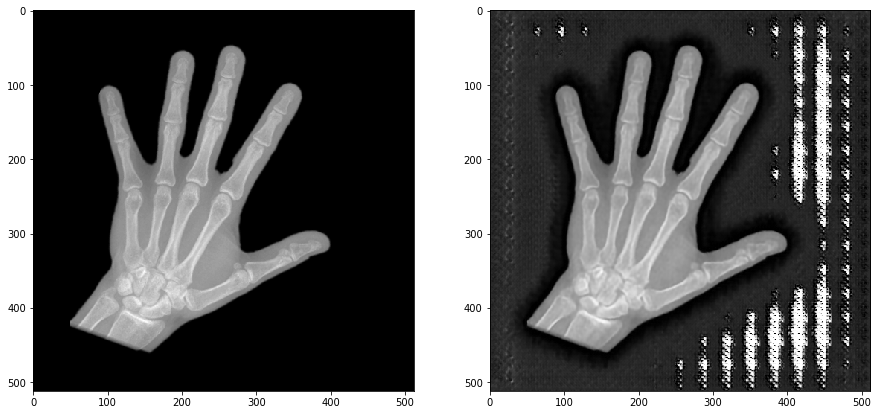

In [51]:
with torch.no_grad():
    output = model(inp_image.view(1, *inp_image.size()))
    output_img = output.to('cpu').numpy()[0][0]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax[0].imshow(inp_image_np[0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(output_img, cmap='gray', vmin=0, vmax=1)
    plt.savefig('baseline_autoencoder_recon.png', dpi=300)

## Bottleneck autoencoder

In [52]:
path_to_model = '/home/ubuntu/mlruns/2/d4fc0453d67b4d5aaac6c353e9264716/artifacts/BottleneckAutoencoder/data/model.pth'

In [53]:
model = torch.load(path_to_model, map_location='cpu')
model.eval().to('cpu')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'src.models.autoencoders.BottleneckAutoencoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'src.models.autoencoders.MaskedMSELoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


BottleneckAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): MaxPool2d(kernel_size=2,

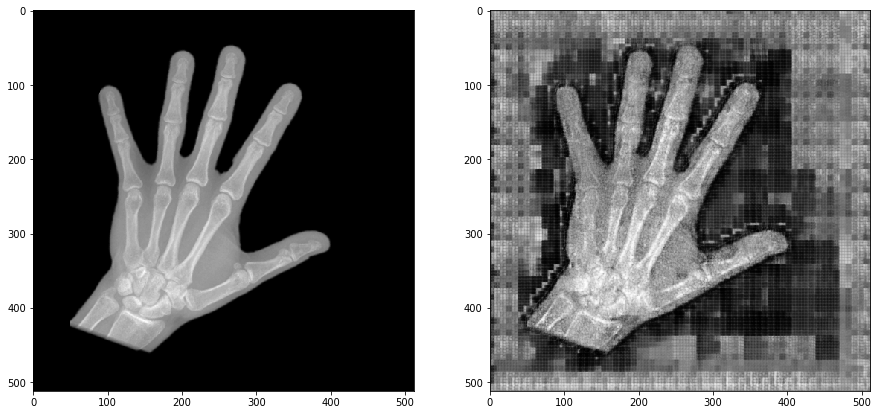

In [54]:
with torch.no_grad():
    output = model(inp_image.view(1, *inp_image.size()))
    output_img = output.to('cpu').numpy()[0][0]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax[0].imshow(inp_image_np[0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(output_img, cmap='gray', vmin=0, vmax=1)
    plt.savefig('bottleneck_autoencoder_recon.png', dpi=300)

## Variational autoencoder 

In [55]:
path_to_model = '/home/diana/xray/models/VAE.pth'

In [56]:
model = torch.load(path_to_model, map_location='cpu')
model.eval().to('cpu')
model.device = 'cpu'

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'src.models.vaetorch.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


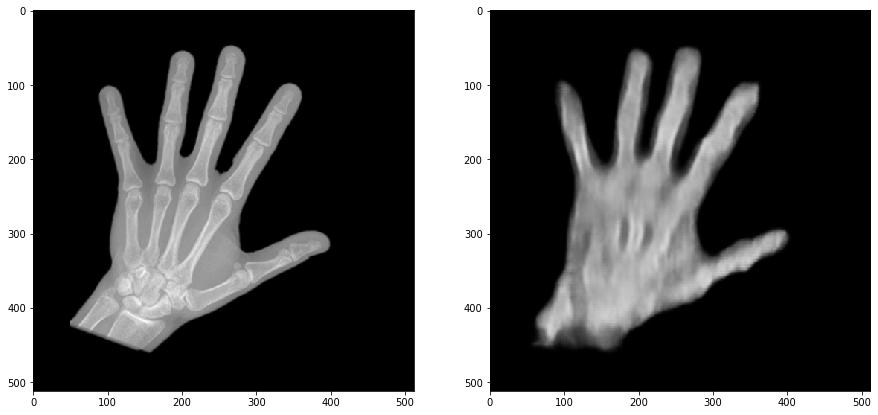

In [57]:
with torch.no_grad():
    output, _, _ = model(inp_image.view(1, *inp_image.size()))
    output_img = output.to('cpu').numpy()[0][0]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax[0].imshow(inp_image_np[0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(output_img, cmap='gray', vmin=0, vmax=1)
    plt.savefig('vae_recon.png', dpi=300)

## BiGAN


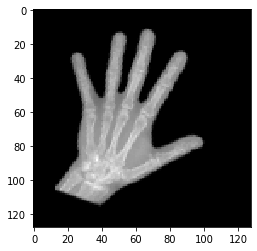

In [249]:
# Loading image
image_path = f'{DATA_PATH}/{run_params["pipeline"]["data_source"]}/patient11178/study1_negative/image3_cropped_1.png'
image_path

run_params = {
    'image_resolution': (128, 128),
    'pipeline': {
        'hist_equalisation': False,
        'data_source': 'XR_HAND_PHOTOSHOP',
    }
}

augmentation_seq = iaa.Sequential([iaa.Affine(fit_output=False, rotate=(20), order=[0, 1]),  
                                   iaa.PadToFixedSize(*run_params['image_resolution'], position='center')])

composed_transforms = Compose([GrayScale(),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               Resize(run_params['image_resolution'], keep_aspect_ratio=True),
                               Augmentation(augmentation_seq),
                               MinMaxNormalization(),
                               ToTensor()])

validation = MURASubset(filenames=[image_path], true_labels=[0],
                        patients=[11178], transform=composed_transforms)

for batch in validation:
    inp_image = batch['image'].to('cpu')
inp_image_np = inp_image.numpy()
plt.imshow(inp_image_np[0,:,:], cmap='gray', vmin=0, vmax=1)
plt.savefig('inp_image.png', dpi=300)

path_to_model = '/home/ubuntu/xray/models/SAGAN200.pth'

In [252]:
model = torch.load(path_to_model, map_location='cpu')
model.eval().to('cpu')
model.device = 'cpu'

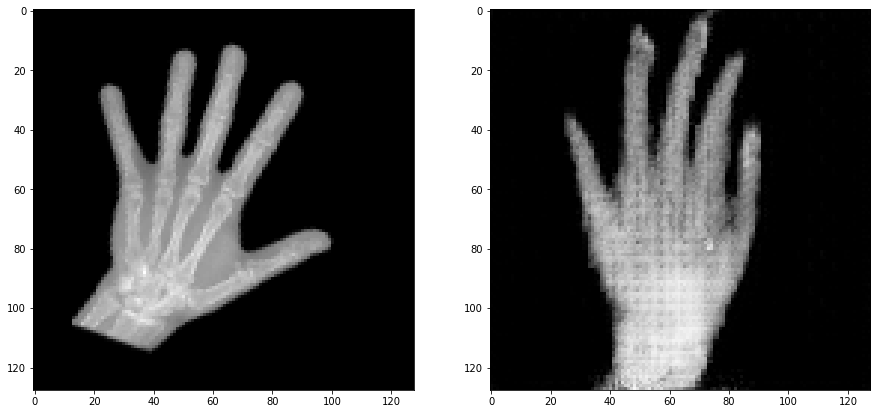

In [253]:
with torch.no_grad():
    # Forward pass
    z, _, _ = model.encoder(inp_image.view(1, *inp_image.size()))
    if len(z.size()) == 1:
        z = z.view(1, z.size(0))
    x_rec, _, _ = model.generator(z)
    output_img = x_rec.numpy()[0]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax[0].imshow(inp_image_np[0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(output_img[0], cmap='gray', vmin=0, vmax=1)
    plt.savefig('bi_gan_recon.png', dpi=300)

In [139]:
with torch.no_grad():
    # Forward pass
    z, _, _ = model.encoder(inp_image.view(1, *inp_image.size()))
    if len(z.size()) == 1:
        z = z.view(1, z.size(0))
    x_rec, _, _ = model.generator(z)
    
    p, x5, x4, x3, out_z, att2, att1 = model.discriminator(inp_image.view(1, *inp_image.size()), z)

In [256]:
run_params = {
    'image_resolution': (128, 128),
    'pipeline': {
        'hist_equalisation': False,
        'data_source': 'XR_HAND_PHOTOSHOP',
    }
}

augmentation_seq = iaa.Sequential([iaa.PadToFixedSize(*run_params['image_resolution'], position='center')])

composed_transforms = Compose([GrayScale(),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               Resize(run_params['image_resolution'], keep_aspect_ratio=True),
                               Augmentation(augmentation_seq),
                               MinMaxNormalization(),
                               ToTensor()])

test = MURASubset(filenames=splitter.data_test.path, true_labels=splitter.data_test.label,
                  patients=splitter.data_test.patient, transform=composed_transforms_val)

test_loader = DataLoader(test, batch_size=20, shuffle=True, num_workers=5)

path_to_model = '/home/ubuntu/xray/models/SAGAN200.pth'

In [257]:
with torch.no_grad():
    scores_mse = []
    scores_proba = []

    true_labels = []
    for batch_data in tqdm(test_loader, total=len(test_loader)):
        # Format input batch
        inp = batch_data['image'].to(model.device)
        mask = batch_data['mask'].to(model.device)

        # Forward pass
        # Forward pass
        real_z, _, _ = model.encoder(inp)
        if len(real_z.size()) == 1:
            real_z = real_z.view(1, real_z.size(0))
        reconstructed_img, _, _ = model.generator(real_z)
        
        loss = model.outer_loss(reconstructed_img, inp, mask) if model.masked_loss_on_val \
            else model.outer_loss(reconstructed_img, inp)

        # Scores, based on output of discriminator - Higher score must correspond to positive labeled images
        proba = model.discriminator(inp, real_z)[0].to('cpu').numpy().reshape(-1)

        # Scores, based on MSE - higher MSE correspond to abnormal image
        if model.masked_loss_on_val:
            sum_loss = loss.to('cpu').numpy().sum(axis=(1, 2, 3))
            sum_mask = mask.to('cpu').numpy().sum(axis=(1, 2, 3))
            score = sum_loss / sum_mask
        else:
            score = loss.to('cpu').numpy().mean(axis=(1, 2, 3))

        scores_mse.extend(score)
        scores_proba.extend(proba)
        true_labels.extend(batch_data['label'].numpy())

    scores_mse = np.array(scores_mse)
    scores_proba = np.array(scores_proba)
    true_labels = np.array(true_labels)


100%|██████████| 72/72 [04:07<00:00,  2.85s/it]


In [261]:
# ROC-AUC and APS
roc_auc = roc_auc_score(true_labels, -scores_proba)
aps = average_precision_score(true_labels, -scores_proba)

print(f'ROC-AUC on test: {roc_auc}')
print(f'APS on test: {aps}')

ROC-AUC on test: 0.5855102794034742
APS on test: 0.6613204409974878


## Alpha Gan

In [262]:
path_to_model = '/home/ubuntu/xray/models/AlphaGan300_best.pth'

In [263]:
model = torch.load(path_to_model, map_location='cpu')
model.eval().to('cpu')
model.device = 'cpu'

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'src.models.alphagan.Codescriminator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


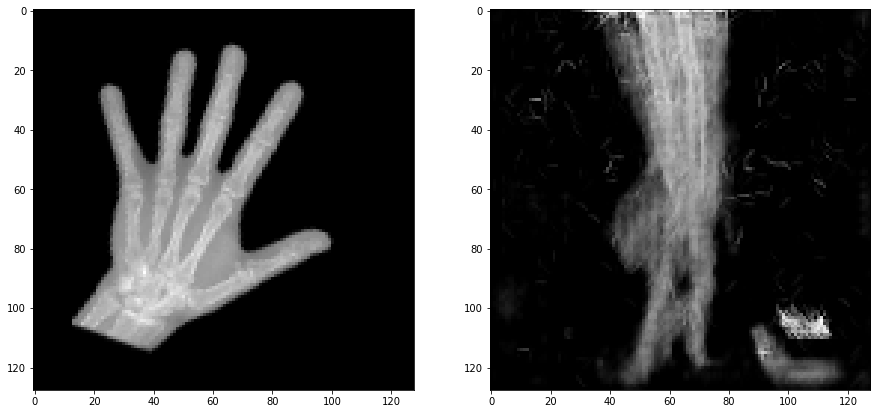

In [264]:
with torch.no_grad():
    # Forward pass
    z_mean, _, _, _ = model.encoder(inp_image.view(1, *inp_image.size()))
    # z_hat = z_mean + z_logvar * torch.randn(z_mean.size()).to(self.device)
    if len(z_mean.size()) == 1:
        z_mean = z_mean.view(1, z_mean.size(0))
    x_rec, _, _ = model.generator(z_mean)
    output_img = x_rec.numpy()[0]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax[0].imshow(inp_image_np[0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(output_img[0], cmap='gray', vmin=0, vmax=1)
    plt.savefig('alpha_gan_recon.png', dpi=300)

In [265]:
data_path = f'{DATA_PATH}/{run_params["pipeline"]["data_source"]}'
splitter = TrainValTestSplitter(path_to_data=data_path)

composed_transforms_val = Compose([GrayScale(),
                                   HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                                   Resize(run_params['image_resolution'], keep_aspect_ratio=True),
                                   Augmentation(iaa.Sequential(
                                       [iaa.PadToFixedSize(*run_params['image_resolution'], position='center')])),
                                   # Padding(max_shape=run_params['image_resolution']),
                                   # max_shape - max size of image after augmentation
                                   MinMaxNormalization(),
                                   ToTensor()])

test = MURASubset(filenames=splitter.data_test.path, true_labels=splitter.data_test.label,
                  patients=splitter.data_test.patient, transform=composed_transforms_val)

test_loader = DataLoader(test, batch_size=18, shuffle=True, num_workers=5)


=================Train subset=================
Size: 3012
Percentage from original data: 0.5145199863341305
Percentage of negatives: 1.0
Number of patients: 1017
=============Validation subset===============
Size: 1419
Percentage from original data: 0.2423983600956611
Percentage of negatives: 0.485553206483439
Number of patients: 473
=================Test subset=================
Size: 1423
Percentage from original data: 0.24308165357020842
Percentage of negatives: 0.4195361911454673
Number of patients: 474


In [266]:
with torch.no_grad():
    scores_mse = []
    scores_proba = []

    true_labels = []
    for batch_data in tqdm(test_loader, total=len(test_loader)):
        # Format input batch
        inp = batch_data['image'].to(model.device)
        mask = batch_data['mask'].to(model.device)

        # Forward pass
        z_mean, z_logvar, _, _ = model.encoder(inp)
        # z_hat = z_mean + z_logvar * torch.randn(z_mean.size()).to(model.device)
        if len(z_mean.size()) == 1:
            z_mean = z_mean.view(1, z_mean.size(0))
        # Decoder (generator)
        x_rec, _, _ = model.generator(z_mean)

        loss = model.outer_loss(x_rec, inp, mask) if model.masked_loss_on_val \
            else model.outer_loss(x_rec, inp)

        # Scores, based on output of discriminator - Higher score must correspond to positive labeled images
        proba = model.discriminator(inp)[0].to('cpu').numpy().reshape(-1)

        # Scores, based on MSE - higher MSE correspond to abnormal image
        if model.masked_loss_on_val:
            sum_loss = loss.to('cpu').numpy().sum(axis=(1, 2, 3))
            sum_mask = mask.to('cpu').numpy().sum(axis=(1, 2, 3))
            score = sum_loss / sum_mask
        else:
            score = loss.to('cpu').numpy().mean(axis=(1, 2, 3))

        scores_mse.extend(score)
        scores_proba.extend(proba)
        true_labels.extend(batch_data['label'].numpy())

    scores_mse = np.array(scores_mse)
    scores_proba = np.array(scores_proba)
    true_labels = np.array(true_labels)

100%|██████████| 80/80 [03:51<00:00,  2.76s/it]


In [267]:
roc_auc = roc_auc_score(true_labels, -scores_proba)
aps = average_precision_score(true_labels, -scores_proba)

print(f'ROC-AUC on test: {roc_auc}')
print(f'APS on test: {aps}')

ROC-AUC on test: 0.5971666240808562
APS on test: 0.6577989854699197


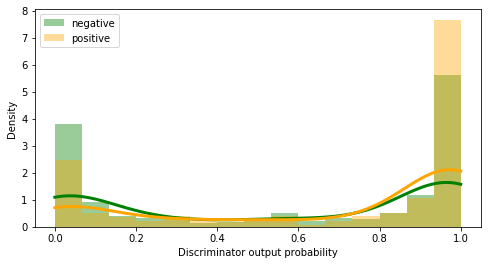

In [248]:
import seaborn as sns
from scipy.stats import norm

fit=norm
colors = ["green","orange"]

color_palette = sns.color_palette(colors)
sns.set_palette(color_palette)

plt.figure(figsize=(8, 4))
sns.distplot(scores_proba[true_labels==1], hist=True, norm_hist=True,
             label='negative', kde_kws={"lw": 3, "clip": [0, 1]}, bins=15)
sns.distplot(scores_proba[true_labels==0], hist=True, norm_hist=True, 
             label='positive', kde_kws={"lw": 3, "clip": [0, 1]}, bins=15)
plt.xlabel('Discriminator output probability')
plt.ylabel('Density')
plt.legend()
plt.savefig('alpha_gan_distribution.png', dpi=300)